# Data 607 &mdash; Winter 2022 &mdash; Assignment 1

## Authors:
    - Andrii Voitkiv, UCID: 30199373
    - Faraz Khan, UCID: 30146190

**Submit a .ipynb file and a Colab link to the solutions to the appropriate D2L dropbox by 23:59 on Wednesday, March 9. For the Colab link, make sure that the permission is set to "Anyone on the internet with this link can view".**

In [4]:
import numpy as np
from matplotlib import pyplot as plt

### Exercise 1: It's nice to have lots of data!

We have observed that training accuracy is often a poor proxy for generalization accuracy. The purpose of this exercise is to demonstrate, in an example, that training accuracy and generalization accuracy are comparable if the training set is sufficiently large.

Here is a function to generate some synthetic classification data:

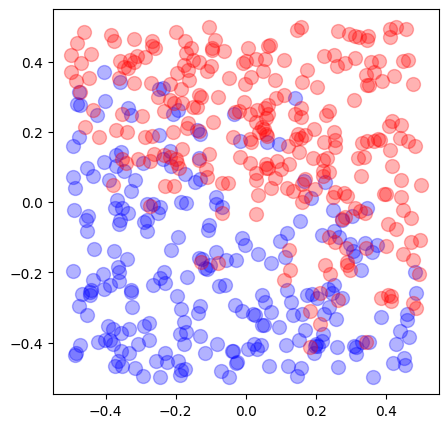

In [5]:
def make_data(size, s=0.15, theta=np.pi/3):
    u = np.array([np.cos(theta), np.sin(theta)])
    X = np.random.uniform(size=(size, 2)) - 0.5
    e = s*np.random.normal(size=size)
    y = 1*(X @ u + e > 0)
    return X, y

X, y = make_data(500)

plt.figure(figsize=(5,5))
ax = plt.gca()
ax.scatter(*X[y == 0].T, color=(0,0,1,0.3), s=100)
ax.scatter(*X[y == 1].T, color=(1,0,0,0.3), s=100)
ax.set_aspect(1)

Let's generate a big testing set for the purpose of estimating generalization  error:

In [6]:
X_te, y_te = make_data(100000)

For each $n$ between $100$ and $100000$ in increments of $100$, train a logistic regression model on a training set of size $n$ generated using `make_data`. Estimate the generalizaton accuracy of this model by the accuracy score on the test set constructed above. On the same axes, plot accuracies on the training set and on testing set versus $n$. Observe the behavior of the accuracy curves for large $n$.

Please label your plots!

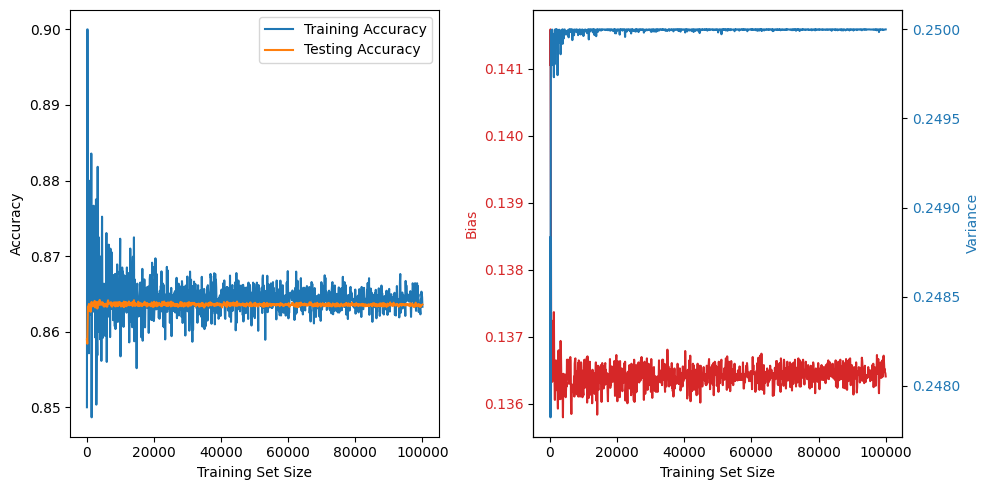

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(0)
n_vals = np.arange(100, 100001, 100)
train_accuracies = []
test_accuracies = []
bias = []
variance = []

for n in n_vals:
    X_tr, y_tr = make_data(n)
    model = LogisticRegression()
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    train_accuracies.append(accuracy_score(y_tr, model.predict(X_tr)))
    test_accuracies.append(accuracy_score(y_te, model.predict(X_te)))
    bias.append(np.mean((y_te - y_pred)**2))
    variance.append(np.mean((y_pred - np.mean(y_pred))**2))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(n_vals, train_accuracies, label='Training Accuracy')
ax1.plot(n_vals, test_accuracies, label='Testing Accuracy')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Accuracy')
ax1.legend()

color = 'tab:red'
ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Bias', color=color)
ax2.plot(n_vals, bias, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('Variance', color=color)  # we already handled the x-label with ax1
ax3.plot(n_vals, variance, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


From the plot above, we can see that the training accuracy and testing accuracy are comparable for large $n$. This is because the training set is large enough that the model is able to learn the true relationship between the features and the target variable.

### Exercise 2: $k$-nearest neighbor regression

Consider a dataset

$$D=\{(x_1, y_1),\ldots,(x_n, y_n)\},$$

where $x_i\in\mathbb{R}^p$ and $y_i\in\mathbb{R}$.

For $x\in\mathbb{R}^p$, let $i_1(x),\ldots,i_n(x)$ be a permutation of the indices $1,\ldots,n$ such that

$$
\|x-x_{i_1(x)}\| \leq \|x-x_{i_2(x)}\| \leq \cdots \leq \|x-x_{i_n(x)}\|.
$$

In particular, $x_{i_1(x)},\ldots,x_{i_k(x)}$ are the $k$-nearest neighbors of $x$ among $x_1,\ldots,x_n$.

The $k$-nearest neighbor regressor $\hat{f}_D$ associated to $D$ is the function that assigns to $x\in \mathbb{R}^p$ the average of the $y$-values associated to the $k$ nearest neighbors of $x$ among $x_1,\ldots,x_n$:

$$
\hat{f}_D(x) = \frac1k \left( y_{i_1(x)} + \cdots + y_{i_k(x)}\right)
$$

In Scikit-Learn, nearest neighbor regressors are instances of the `KNeighborsRegressor` class, which can be imported from `sklearn.neighbors`. Like its classifier counterpart, `KNeighborsRegressor` takes a keyword argument `n_neighbors`, defaulting to `5`.

Here is some code to generate synthetic $1$-dimensional data for a regression problem. The data is distributed around the curve

$$
f(x) = \sqrt{x}\sin^2(2\pi x).
$$

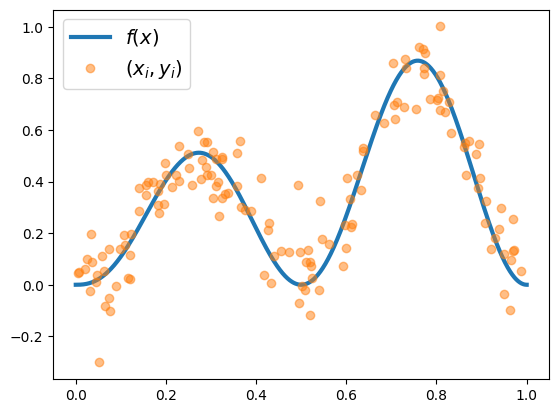

In [8]:
def f(x):
    return np.sqrt(x)*np.sin(2*np.pi*x)**2

def make_data(size, s=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    x = np.random.uniform(size=size)
    y = f(x) + s*np.random.normal(size=size)
    return x, y

x, y = make_data(150, random_state=42)
t = np.linspace(0, 1, 1000)
plt.plot(t, f(t), lw=3, label="$f(x)$")
plt.plot(x, y, "o", label="$(x_i, y_i)$", alpha=0.5)
plt.legend(loc="upper left", fontsize=14)
plt.show()

Split the dataset 80%/20% into a training set and a testing set.

Identify an optimal value for `n_neighbors` by randomly splitting training data 80%/20% into a training subset and a validation subset 200 times, imitating the procedure demonstrated in class for nearest neighbor classifiers. The optimal value for `n_neighbors` is the one that minimizes the average mean squared validation error, averaged over all 200 splittings.

Once you've identified an optimal value for `n_neighbors`, refit the model on the original training set and compute the mean squared error on the test set.

Plot the overlay a plot of your $k$-nearest neighbors regressor $\hat{f}_D$ on the curve $f(x)$.

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

# Split the dataset 80%/20% into a training set and a testing set.
X_tr, X_te, y_tr, y_te = train_test_split(x, y, test_size=0.2)
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape);

(120,) (30,) (120,) (30,)


  0%|          | 0/200 [00:00<?, ?it/s]

9


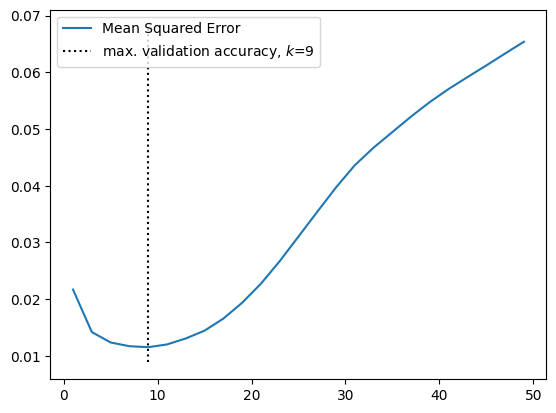

In [10]:
# Identify an optimal value for n_neighbors
ks = np.arange(1, 50, 2)

n_repeats = 200
mse_val = np.zeros((n_repeats, len(ks)))

for i in tqdm(range(n_repeats)):
    U_tr, U_val, v_tr, v_val = train_test_split(X_tr, y_tr, test_size=0.2)
    for j, k in enumerate(ks):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(U_tr.reshape(-1, 1), v_tr)
        mse_val[i, j] = mean_squared_error(v_val, model.predict(U_val.reshape(-1, 1)))

scores = mse_val.mean(axis=0)
k = ks[np.argmin(scores)]
print("Optimal k:", k)

# Plot ks vs scores
plt.plot(ks, scores, label="Mean Squared Error")
# plt.axvline(k, color="red", label="Optimal k")
plt.vlines(k, *plt.ylim(), colors="k", linestyles=":", label=f"max. validation accuracy, $k$={k}")
plt.legend()
plt.show()



Mean Squared Error on the test set: 0.01189957782174287


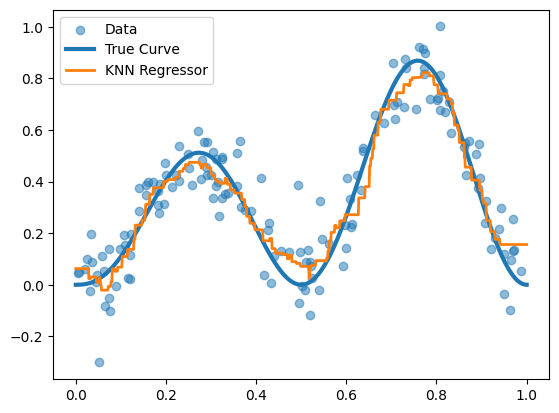

In [11]:
# Refit the model on the original training set and compute MSE on the test set
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_tr.reshape(-1, 1), y_tr)
mse_te = mean_squared_error(y_te, model.predict(X_te.reshape(-1, 1)))
print("Mean Squared Error on the test set:", mse_te)

# Plot the overlay of the k-nearest neighbors regressor on the curve f(x)
x_range = np.linspace(0, 1, 1000)
y_range = f(x_range)
y_hat = model.predict(x_range.reshape(-1, 1))

plt.scatter(x, y, alpha=0.5, label="Data")
plt.plot(x_range, y_range, lw=3, label="True Curve")
plt.plot(x_range, y_hat, lw=2, label="KNN Regressor")
plt.legend()
plt.show()

KNN regression approximates the true curve $f(x)$ very well.

### Exercise 3: Polynomial Regression

Repeat Exercise 2, but with polynomial regression (i.e., a pipeline composed of `PolynomialFeatures` and `LinearRegression`) in place of `KNeighborsRegressor` and the `degree` parameter of `PolynomialFeatures` instead of `n_neighbors`.

  0%|          | 0/200 [00:00<?, ?it/s]

7


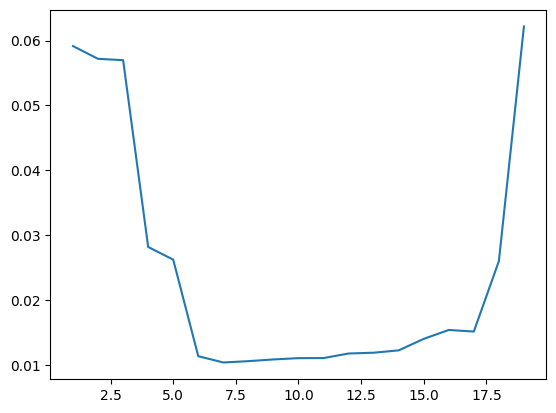

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Identify an optimal value for degree
degrees = np.arange(1, 20)
n_repeats = 200
mse_val = np.zeros((n_repeats, len(degrees)))

for i in tqdm(range(n_repeats)):
    U_tr, U_val, v_tr, v_val = train_test_split(X_tr, y_tr, test_size=0.2)
    for j, degree in enumerate(degrees):
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(U_tr.reshape(-1, 1), v_tr)
        mse_val[i, j] = mean_squared_error(v_val, model.predict(U_val.reshape(-1, 1)))

scores = mse_val.mean(axis=0)
degree = degrees[np.argmin(scores)]
print(degree)

plt.plot(degrees, scores)

0.01403869256200562


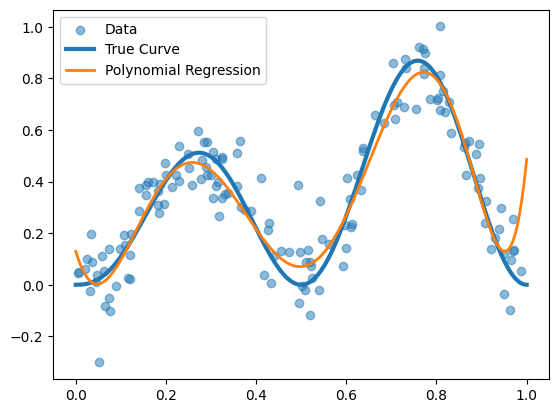

In [13]:
# Fit the final model on the original training data and evaluate on the test data
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_tr.reshape(-1, 1), y_tr)
mse_te = mean_squared_error(y_te, model.predict(X_te.reshape(-1, 1)))
print(mse_te)

# Plot the overlay of the Polynomial Regression on the curve f(x)
x_range = np.linspace(0, 1, 1000)
y_range = f(x_range)
y_hat = model.predict(x_range.reshape(-1, 1))

plt.scatter(x, y, alpha=0.5, label="Data")
plt.plot(x_range, y_range, lw=3, label="True Curve")
plt.plot(x_range, y_hat, lw=2, label="Polynomial Regression")
plt.legend()
plt.show()

### Exercise 4: Diabetes Data

In this exercise, we use the diabetes dataset built into Scikit-Learn. See the [User Guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) for information on the dataset.

1. Split the dataset 80%/20% into a training set and a testing set.

2. Fit a linear regression model to the training set. Report the mean squared error on the test set.

3. Using the method of Exercise 2, find an optimal value of `n_neighbors` for a `KNeighborsRegressor` fit to the training data. Once you've identified an optimal value for `n_neighbors`, refit the model on the original training set and compute the mean squared error on the test set.

4. How do the linear regression model and the $k$-nearest neighbors model compare?


In [14]:
# Import the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the dataset into a training set and a testing set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(353, 10) (89, 10) (353,) (89,)


In [15]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model to the training set
model = LinearRegression()
model.fit(X_tr, y_tr)

# Report the mean squared error on the test set
mse_te = mean_squared_error(y_te, model.predict(X_te))
print("Mean Squared Error on the test set (Linear Regression):", mse_te)

Mean Squared Error on the test set (Linear Regression): 3115.571300704899


  0%|          | 0/200 [00:00<?, ?it/s]

19


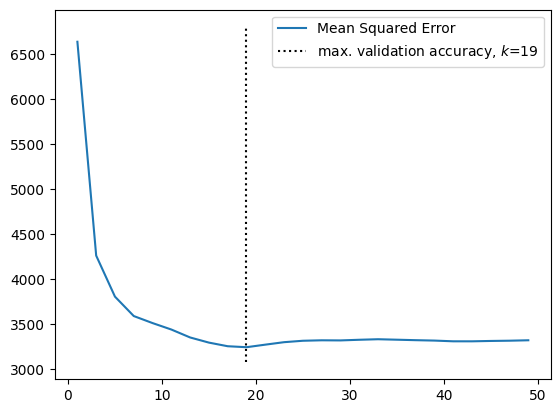

In [16]:
# Identify an optimal value for n_neighbors
ks = np.arange(1, 50, 2)

n_repeats = 200
mse_val = np.zeros((n_repeats, len(ks)))

for i in tqdm(range(n_repeats)):
    U_tr, U_val, v_tr, v_val = train_test_split(X_tr, y_tr, test_size=0.2)
    for j, k in enumerate(ks):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(U_tr, v_tr)
        mse_val[i, j] = mean_squared_error(v_val, model.predict(U_val))

scores = mse_val.mean(axis=0)
k = ks[np.argmin(scores)]
print(k)

# Plot ks vs scores
plt.plot(ks, scores, label="Mean Squared Error")
# plt.axvline(k, color="red", label="Optimal k")
plt.vlines(k, *plt.ylim(), colors="k", linestyles=":", label=f"max. validation accuracy, $k$={k}")
plt.legend()
plt.show()

In [17]:
# Refit the model on the original training set and compute MSE on the test set
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_tr, y_tr)
mse_te = mean_squared_error(y_te, model.predict(X_te))
print("Mean Squared Error on the test set (KNN):", mse_te)

Mean Squared Error on the test set (KNN): 3545.811478726385


_How do the linear regression model and the $k$-nearest neighbors model compare?_

The linear regression model has a lower mean squared error than the $k$-nearest neighbors model. This could be because:
1) the linear regression model makes the assumption of a **linear relationship** between the independent and dependent variables, which might be a better fit for the data than the non-parametric KNN algorithm.
2) It could also mean that the KNN algorithm is **overfitting** the data, which is common in non-parametric models, and the linear regression model is better at avoiding overfitting.

### Exercise 5: Breast Cancer Data

In this exercise, we use the breast cancer Wisconsin dataset built into Scikit-Learn. See the [User Guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset) for information on the dataset. Note that this dataset is for classification rather than regression.

1. Split the dataset 80%/20% into a training set and a testing set.

2. Fit a logistic regression model to the training set. Report the classification accuracy on the test set.

3. Using a cross-validated grid search (`GridSeachCV`), find an optimal support vector classifier fit to the training set. Support vector classifiers are instances of the `SVC` class, importable from `sklearn.svm`. Search over values of the parameter `C` in `[0.001, 0.01, 0.1, 1, 10, 100, 1000]` and `kernel` in `["linear", "rbf", "poly"]`. Report the best values for `C` and `kernel` and the classification accuracy on the test set associated to the best model.

4. How do the logistic regression classifier and the support vector classifier compare?



In [18]:
# Import the breast cancer dataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split the dataset into a training set and a testing set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(455, 30) (114, 30) (455,) (114,)


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Fit a logistic regression model to the training set
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_tr, y_tr)

# Report the classification accuracy on the test set
acc_te = accuracy_score(y_te, model.predict(X_te))
print("Classification Accuracy on the test set (Logistic Regression):", acc_te)

Classification Accuracy on the test set (Logistic Regression): 0.9912280701754386


In [20]:
# Find an optimal support vector classifier fit to the training set
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVC())
param_grid = {
    "svc__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "svc__kernel": ["linear", "rbf", "poly"]
}

search = GridSearchCV(model, param_grid=param_grid, cv=5, return_train_score=True, scoring="accuracy")

search.fit(X_tr, y_tr)

# Report the best values for C and kernel and the classification accuracy on the test set associated to the best model
print("Best parameters:", search.best_params_)
print("Best cross-validation score:", search.best_score_)
print("Test set score:", search.score(X_te, y_te))


Best parameters: {'svc__C': 10, 'svc__kernel': 'rbf'}
Best cross-validation score: 0.9824175824175825
Test set score: 0.9736842105263158


In [21]:
# Plot the results of the grid search
import pandas as pd

results_df = pd.DataFrame(search.cv_results_)
# Sort by mean test score
results_df = results_df.sort_values(by="mean_test_score", ascending=False)
results_df[['params', 'mean_test_score']].head()

,params,mean_test_score
13,"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.982418
6,"{'svc__C': 0.1, 'svc__kernel': 'linear'}",0.980220
10,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.971429
19,"{'svc__C': 1000, 'svc__kernel': 'rbf'}",0.969231
16,"{'svc__C': 100, 'svc__kernel': 'rbf'}",0.969231


__How do the logistic regression classifier and the support vector classifier compare?__
Both models have very high classification accuracy on the test set. The logistic regression classifier has a slightly higher accuracy than the support vector classifier. This could be because the logistic regression classifier is a **linear model** and the support vector classifier is a **non-linear model**, as it uses `rbf` kernel function, which maps data points into higher dimensional space, allowing the algorithm to find a non-linear decision boundary that separates the data points with a larger margin.